In [1]:
# Install necessary packages

!pip install tensorflow==2.10.0
!pip install keras==2.10.0
!pip install tensorflow-text==2.10.0
!pip install moviepy
!pip install autokeras==1.1.0
!pip install --upgrade keras_nlp
!pip install pydot
!pip install graphviz
!pip install opencv-python
!pip install psutil
!pip install scikit-learn
!pip install memory-profiler
!pip install keras_nlp==0.4.0
!pip install imbalanced-learn

  Using cached keras_nlp-0.17.0-py3-none-any.whl.metadata (1.2 kB)
Using cached keras_nlp-0.17.0-py3-none-any.whl (2.0 kB)
  Attempting uninstall: keras_nlp
    Found existing installation: keras-nlp 0.4.0
    Uninstalling keras-nlp-0.4.0:
      Successfully uninstalled keras-nlp-0.4.0
  Using cached keras_nlp-0.4.0-py3-none-any.whl.metadata (6.4 kB)
Using cached keras_nlp-0.4.0-py3-none-any.whl (337 kB)
  Attempting uninstall: keras_nlp
    Found existing installation: keras-nlp 0.17.0
    Uninstalling keras-nlp-0.17.0:
      Successfully uninstalled keras-nlp-0.17.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Imports and setup
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve,auc,classification_report,roc_auc_score,confusion_matrix
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import autokeras as ak
import time
from memory_profiler import memory_usage
import random
import shutil
from moviepy.video.io.VideoFileClip import VideoFileClip
import h5py
import gc
import psutil
import time
import librosa
import torch
import torchaudio
import seaborn as sns
from skimage.transform import resize
import shutil
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define the source and destination directories
source_dir_youtube_real = '/content/drive/My Drive/DeepFakeThesis/Celeb-DF-v2/YouTube-real'
source_dir_celeb_real = '/content/drive/My Drive/DeepFakeThesis/Celeb-DF-v2/Celeb-real'
source_dir_fake = '/content/drive/My Drive/DeepFakeThesis/Celeb-DF-v2/Celeb-synthesis'
destination_dir_real = '/content/drive/My Drive/DeepFakeThesis/working/dataset/Real'
destination_dir_fake = '/content/drive/My Drive/DeepFakeThesis/working/dataset/Fake'
frames_real_output = '/content/drive/My Drive/DeepFakeThesis/working/dataset/frames_real'
frames_fake_output = '/content/drive/My Drive/DeepFakeThesis/working/dataset/frames_fake'


In [6]:
path = '/content/drive/My Drive/DeepFakeThesis/Celeb-DF-v2/Celeb-real'
if os.path.exists(path):
    print("Directory exists.")
else:
    print("Directory not found. Please check the path.")


Directory exists.


In [7]:
#shutil.rmtree("/content/drive/My Drive/DeepFakeThesis/working/dataset")

In [8]:
# Check if destination directories already contain files
if os.path.exists(destination_dir_real) and os.listdir(destination_dir_real):
    print("REAL files are already in the destination directory.")
else:
    # Create destination directory if it does not exist
    os.makedirs(destination_dir_real, exist_ok=True)

    # Combine REAL video sources
    source_dirs_real = [source_dir_youtube_real, source_dir_celeb_real]

    # Copy REAL videos from all source directories to the destination
    for source_dir in source_dirs_real:
        file_list_real = os.listdir(source_dir)
        for filename in file_list_real:
            source_file = os.path.join(source_dir, filename)
            destination_file = os.path.join(destination_dir_real, filename)
            # Check if the file already exists in the destination
            if not os.path.exists(destination_file):
                shutil.copy(source_file, destination_file)
            else:
                print(f"{filename} already exists in {destination_dir_real}, skipping.")

if os.path.exists(destination_dir_fake) and os.listdir(destination_dir_fake):
    print("FAKE files are already in the destination directory.")
else:
#    # Create destination directory if it does not exist
    os.makedirs(destination_dir_fake, exist_ok=True)

    # Get the list of FAKE videos
    file_list_fake = os.listdir(source_dir_fake)

    # Copy all FAKE videos to the destination
    for filename in file_list_fake:
        source_file = os.path.join(source_dir_fake, filename)
        destination_file = os.path.join(destination_dir_fake, filename)
        # Check if the file already exists in the destination
        if not os.path.exists(destination_file):
            shutil.copy(source_file, destination_file)
        else:
            print(f"{filename} already exists in {destination_dir_fake}, skipping.")

print("File copying process completed.")


REAL files are already in the destination directory.
FAKE files are already in the destination directory.
File copying process completed.


In [9]:
print(f"Total real videos: {len(os.listdir(destination_dir_real))}")
print(f"Total fake videos: {len(os.listdir(destination_dir_fake))}")


Total real videos: 890
Total fake videos: 5639


In [10]:
def extract_frames_if_not_exists(source_dir, output_dir, num_frames=10, debug_limit=5):

    os.makedirs(output_dir, exist_ok=True)

    # List all video files
    video_files = [os.path.join(source_dir, file) for file in os.listdir(source_dir) if file.endswith(('.mp4', '.avi', '.mov'))]

    print(f"Found {len(video_files)} videos in {source_dir}")
    debug_count = 0

    for video_path in video_files:
        video_name = os.path.splitext(os.path.basename(video_path))[0]  # Extract video name
        video_output_dir = os.path.join(output_dir, video_name)

        # Skip extraction if frames already exist
        if os.path.exists(video_output_dir) and os.listdir(video_output_dir):
            continue

        os.makedirs(video_output_dir, exist_ok=True)

        # Open video file
        video_capture = cv2.VideoCapture(video_path)
        frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

        for frame_num in range(min(frame_count, num_frames)):
            ret, frame = video_capture.read()
            if not ret:
                print(f"Failed to read frame {frame_num} from {video_path}")
                break

            # Save frame as image
            frame_filename = os.path.join(video_output_dir, f"frame_{frame_num:03d}.jpg")
            cv2.imwrite(frame_filename, frame)


        video_capture.release()

        # Increment debug count for the first few videos
        if debug_count < debug_limit:
            debug_count += 1


    print(f"Frame extraction completed for {len(video_files)} videos. Frames saved in {output_dir}")


In [11]:
def print_extracted_frames(output_dir, num_videos_to_print=5, num_frames_to_print=3):
    video_folders = [os.path.join(output_dir, folder) for folder in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, folder))]
    if not video_folders:
        print(f"No extracted frames found in {output_dir}. Please extract frames first.")
        return

    print(f"Found {len(video_folders)} videos in {output_dir}")

    for video_folder in video_folders[:num_videos_to_print]:
        video_name = os.path.basename(video_folder)
        print(f"Printing frames for video: {video_name}")

        frame_files = sorted([os.path.join(video_folder, file) for file in os.listdir(video_folder) if file.endswith('.jpg')])

        for frame_file in frame_files[:num_frames_to_print]:
            frame = cv2.imread(frame_file)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame from {video_name}")
            plt.axis("off")
            plt.show()


In [12]:
def apply_augmentation(frame):
    # Random horizontal flip
    if random.random() > 0.5:
        frame = cv2.flip(frame, 1)

    # Random brightness adjustment
    if random.random() > 0.5:
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        brightness_factor = 0.9 + 0.2 * random.random()  # Keep brightness adjustments subtle
        hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)
        frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Random rotation
    if random.random() > 0.5:
        angle = random.randint(-15, 15)
        h, w = frame.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
        frame = cv2.warpAffine(frame, M, (w, h))

    return frame


In [13]:
def multimodal_fusion(frame):
    # Convert RGB to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # Expand dimensions to match RGB
    gray = np.expand_dims(gray, axis=2)
    # Concatenate grayscale channel with RGB
    fused_frame = np.concatenate((frame, gray), axis=2)
    return fused_frame


In [14]:
def preprocess_and_save_h5_optimized(
    frames_real_output,
    frames_fake_output,
    h5_file_path,
    augment=False,
    fusion=False,
    target_shape=(10, 64, 64, 4),
    num_workers=8
):
    def parse_frames(video_folder, label):

        frame_files = sorted(
            [os.path.join(video_folder, file) for file in os.listdir(video_folder) if file.endswith('.jpg')]
        )
        frames = []

        for frame_file in frame_files:
            # Read the image
            frame = cv2.imread(frame_file)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Apply augmentation
            if augment:
                frame = apply_augmentation(frame)

            # Apply multimodal fusion
            if fusion:
                frame = multimodal_fusion(frame)

            # Resize to target shape
            frame = cv2.resize(frame, (target_shape[2], target_shape[1]))

            # Normalize to [0, 1]
            frame = frame / 255.0
            frame = np.clip(frame, 0, 1)  # Clip values to ensure they fall in range [0, 1]

            frames.append(frame)

        # Pad or trim to match the required number of frames
        if len(frames) < target_shape[0]:
            padding_frames = [np.zeros((target_shape[1], target_shape[2], target_shape[3]))] * (target_shape[0] - len(frames))
            frames.extend(padding_frames)

        frames = np.array(frames[:target_shape[0]])

        return frames, label

    def process_video_folder(frame_dir, label, max_videos=None):

        video_folders = [os.path.join(frame_dir, folder) for folder in os.listdir(frame_dir) if os.path.isdir(os.path.join(frame_dir, folder))]

        if max_videos:
            video_folders = video_folders[:max_videos]

        # Process folders in parallel
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(executor.map(lambda folder: parse_frames(folder, label), video_folders))

        # Separate frames and labels
        video_data, labels = zip(*results)
        return np.array(video_data), np.array(labels)

    # Process real videos
    print("Loading and preprocessing real videos")
    real_data, real_labels = process_video_folder(frames_real_output, label=0)

    # Process fake videos
    print("Loading and preprocessing fake videos")
    fake_data, fake_labels = process_video_folder(frames_fake_output, label=1)

    # Combine datasets
    video_data = np.concatenate((real_data, fake_data), axis=0)
    labels = np.concatenate((real_labels, fake_labels), axis=0)

    # Shuffle dataset
    indices = np.arange(video_data.shape[0])
    np.random.shuffle(indices)
    video_data = video_data[indices]
    labels = labels[indices]

    # Save to HDF5
    print(f"Saving preprocessed data to {h5_file_path}")
    with h5py.File(h5_file_path, 'w') as h5_file:
        h5_file.create_dataset('X', data=video_data, compression='gzip')
        h5_file.create_dataset('y', data=labels, compression='gzip')
    print(f"Data saved successfully to {h5_file_path}")


In [15]:
def check_h5_and_preprocess_or_load(frames_real_output, frames_fake_output, h5_file_path, augment=True, normalize=True, fusion=False):

    if os.path.exists(h5_file_path):
        print(f"HDF5 file found at {h5_file_path}.")
        with h5py.File(h5_file_path, 'r') as h5_file:
            X = h5_file['X'][:]
            y = h5_file['y'][:]
        print(f"Loaded {len(X)} videos from {h5_file_path}")
    else:
        print(f"HDF5 file not found at {h5_file_path}. Preprocessing data")
        preprocess_and_save_h5_optimized(
    frames_real_output,
    frames_fake_output,
    h5_file_path,
    augment=True,
    fusion=True,
    target_shape=(10, 64, 64, 4),
    num_workers=8
)
        # Load the newly saved data
        with h5py.File(h5_file_path, 'r') as h5_file:
            X = h5_file['X'][:]
            y = h5_file['y'][:]
        print(f"Preprocessed and saved {len(X)} videos to {h5_file_path}")
    return X, y


In [16]:
def print_preprocessed_frames(h5_file_path, num_videos_to_print=5, num_frames_to_print=3):

    if not os.path.exists(h5_file_path):
        print(f"HDF5 file not found at {h5_file_path}. Please preprocess the data first.")
        return

    with h5py.File(h5_file_path, 'r') as h5_file:
        X = h5_file['X'][:]
        y = h5_file['y'][:]

    print(f"Loaded {len(X)} videos from {h5_file_path}")

    for video_idx in range(min(num_videos_to_print, len(X))):
        video_frames = X[video_idx]
        label = y[video_idx]
        print(f"Video {video_idx + 1}/{len(X)} | Label: {'Real' if label == 0 else 'Fake'} | Total Frames: {len(video_frames)}")

        for frame_idx in range(min(num_frames_to_print, len(video_frames))):
            frame = video_frames[frame_idx]
            plt.imshow(frame[:, :, :3] if frame.shape[2] > 3 else frame)  # Handle RGB + Grayscale case
            plt.title(f"Video {video_idx + 1} | Frame {frame_idx + 1}")
            plt.axis("off")
            plt.show()


In [17]:
# Extract frames
extract_frames_if_not_exists(destination_dir_real, frames_real_output, num_frames=10, debug_limit=5)
extract_frames_if_not_exists(destination_dir_fake, frames_fake_output, num_frames=10, debug_limit=5)

Found 890 videos in /content/drive/My Drive/DeepFakeThesis/working/dataset/Real
Frame extraction completed for 890 videos. Frames saved in /content/drive/My Drive/DeepFakeThesis/working/dataset/frames_real
Found 5639 videos in /content/drive/My Drive/DeepFakeThesis/working/dataset/Fake
Frame extraction completed for 5639 videos. Frames saved in /content/drive/My Drive/DeepFakeThesis/working/dataset/frames_fake


Found 890 videos in /content/drive/My Drive/DeepFakeThesis/working/dataset/frames_real
Printing frames for video: 00290


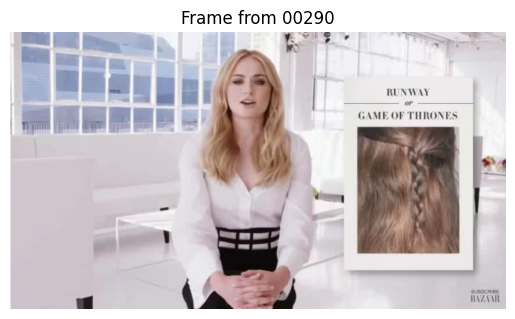

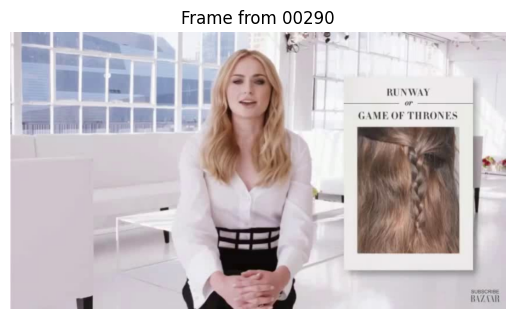

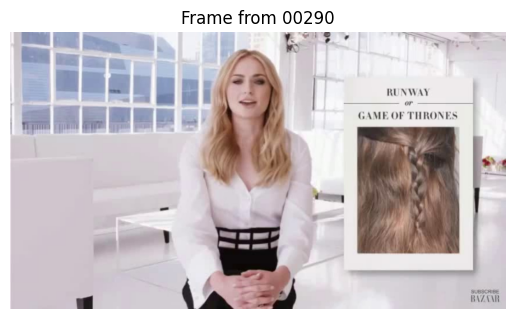

Printing frames for video: 00288


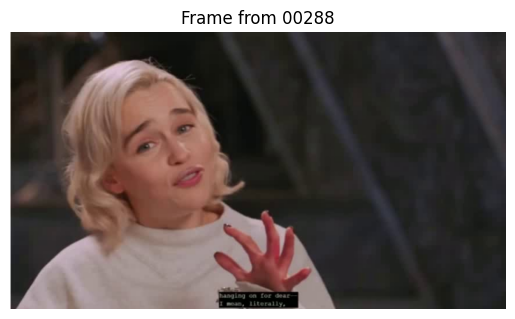

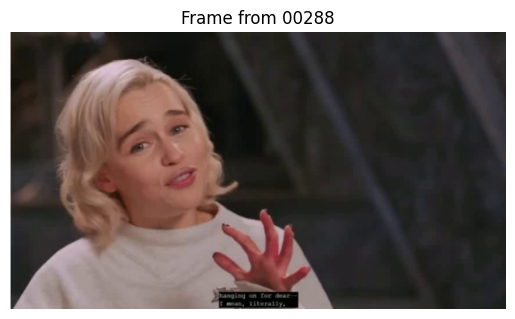

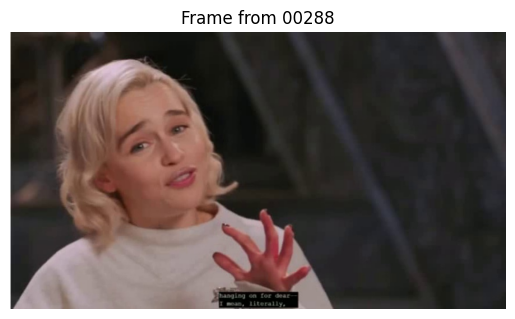

Printing frames for video: 00285


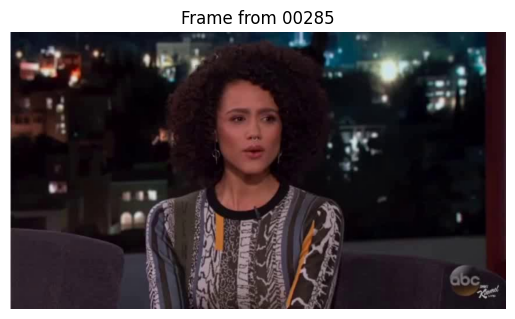

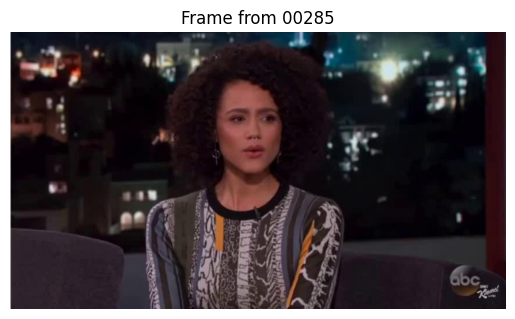

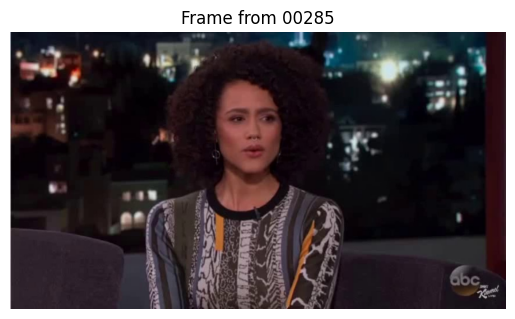

Printing frames for video: 00289


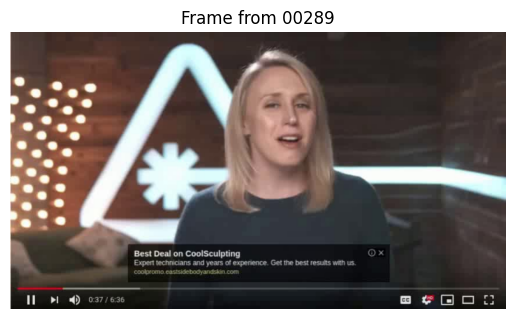

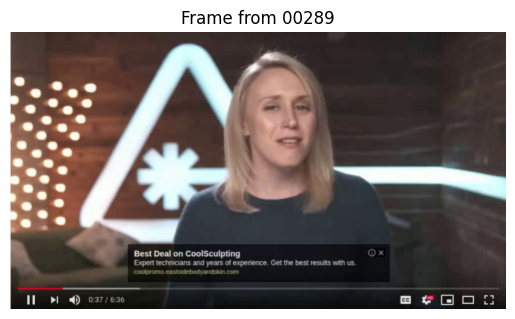

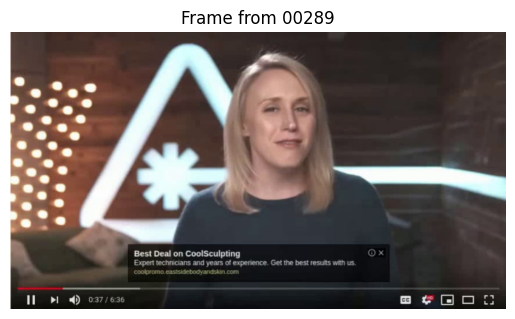

Printing frames for video: 00286


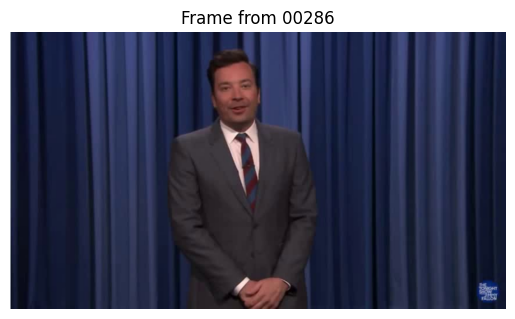

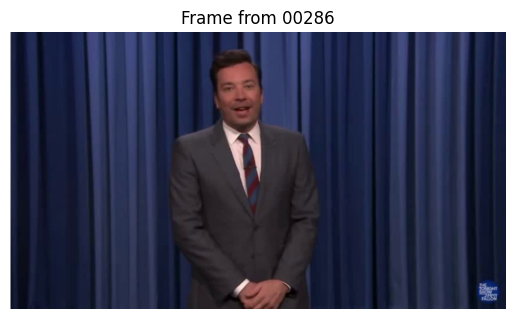

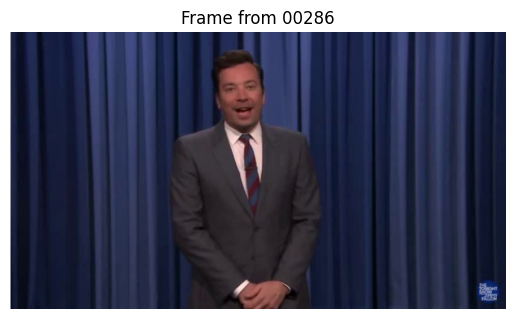

Found 5639 videos in /content/drive/My Drive/DeepFakeThesis/working/dataset/frames_fake
Printing frames for video: id35_id20_0009


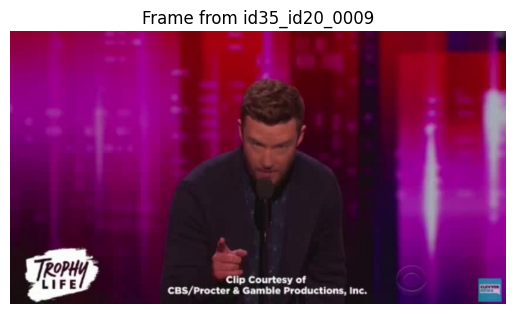

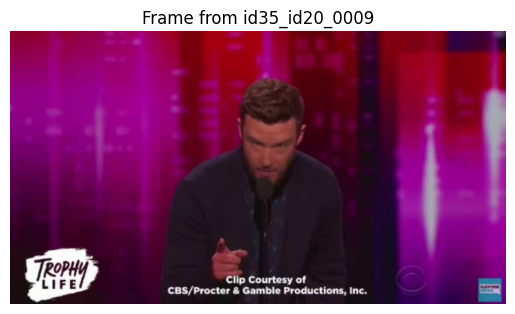

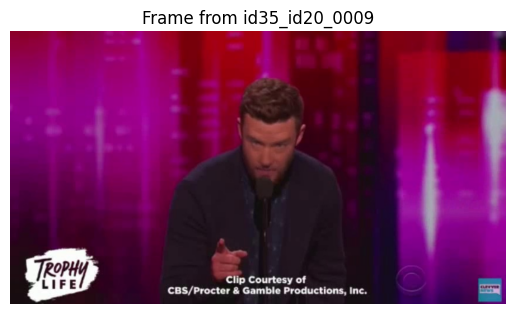

Printing frames for video: id35_id20_0007


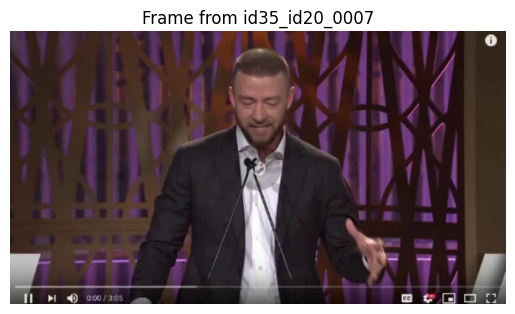

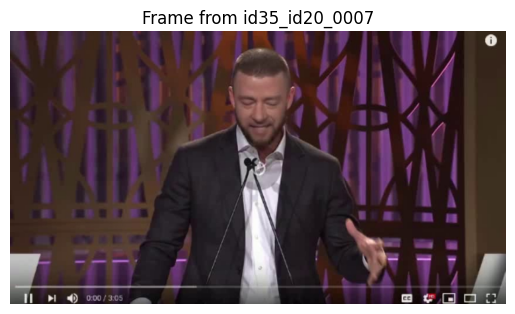

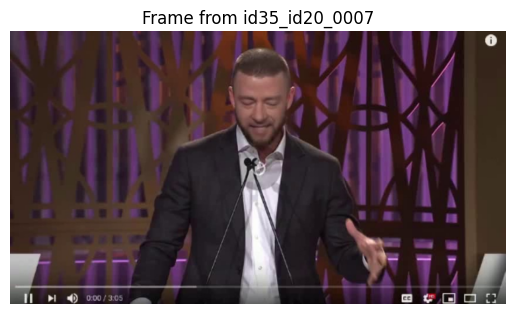

Printing frames for video: id35_id1_0001


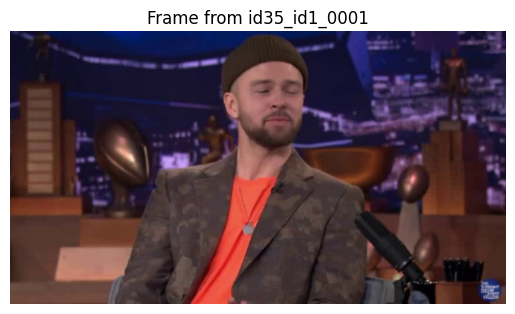

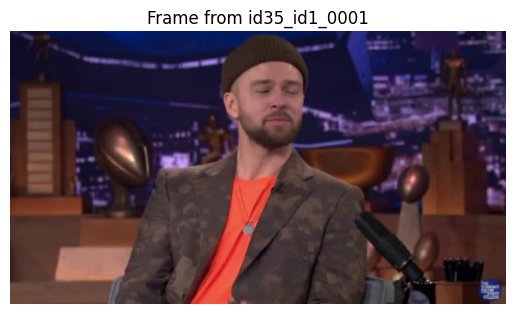

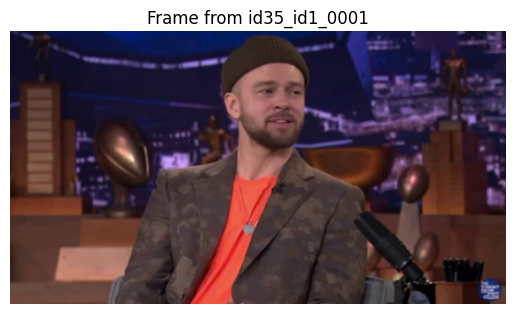

Printing frames for video: id35_id21_0003


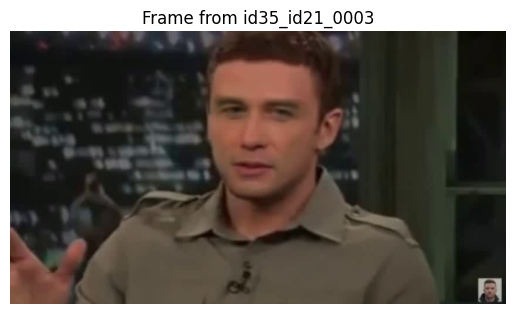

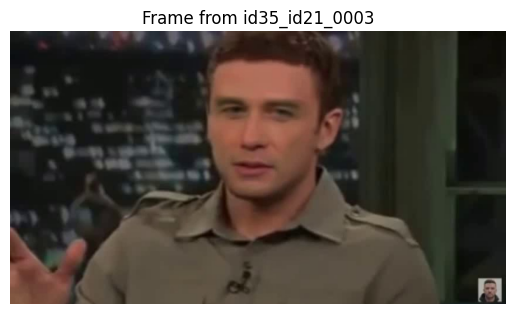

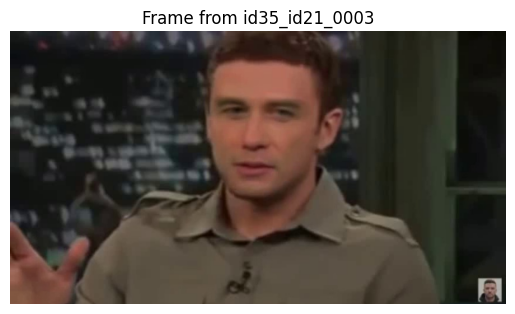

Printing frames for video: id35_id23_0000


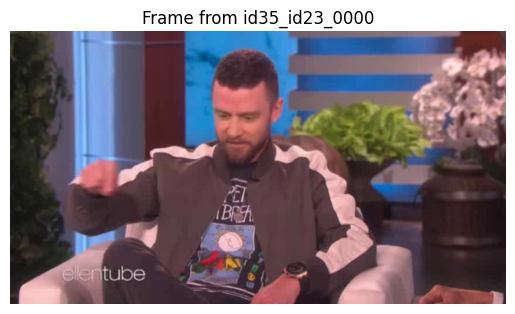

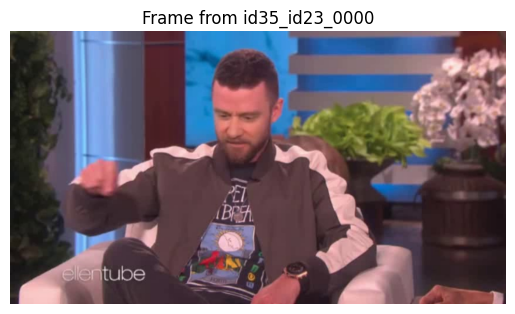

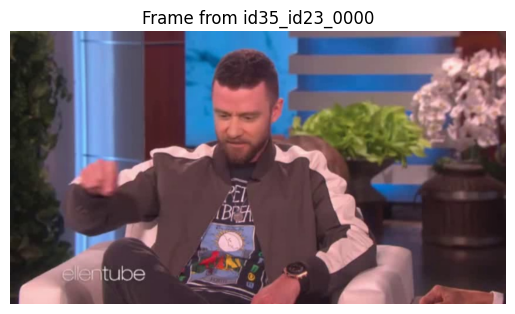

In [18]:
# Print extracted frames
print_extracted_frames(frames_real_output, num_videos_to_print=5, num_frames_to_print=3)
print_extracted_frames(frames_fake_output, num_videos_to_print=5, num_frames_to_print=3)

In [19]:
h5_file_path = '/content/drive/My Drive/DeepFakeThesis/working/dataset/data.h5'

X, y = check_h5_and_preprocess_or_load(
    frames_real_output=frames_real_output,
    frames_fake_output=frames_fake_output,
    h5_file_path=h5_file_path,
    augment=True,
    normalize=True,
    fusion=True
)


HDF5 file found at /content/drive/My Drive/DeepFakeThesis/working/dataset/data.h5.
Loaded 6529 videos from /content/drive/My Drive/DeepFakeThesis/working/dataset/data.h5


Loaded 6529 videos from /content/drive/My Drive/DeepFakeThesis/working/dataset/data.h5
Video 1/6529 | Label: Fake | Total Frames: 10


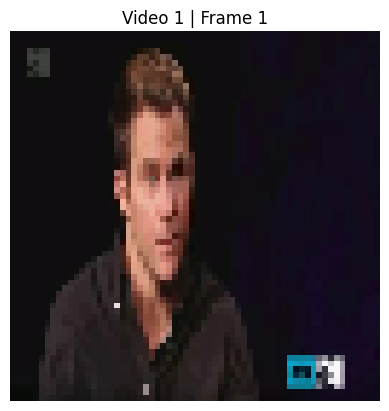

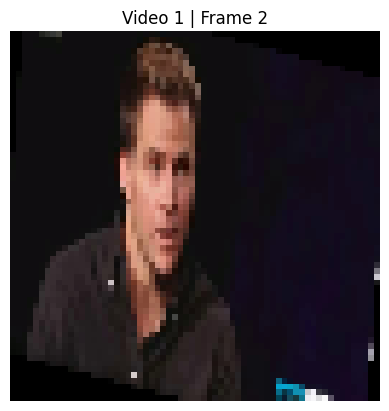

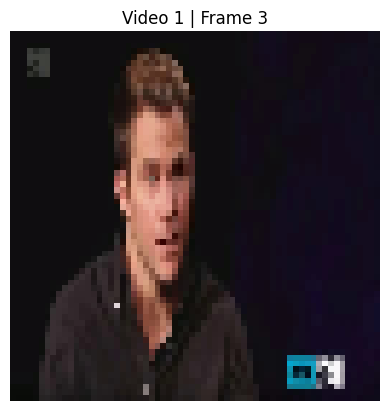

Video 2/6529 | Label: Fake | Total Frames: 10


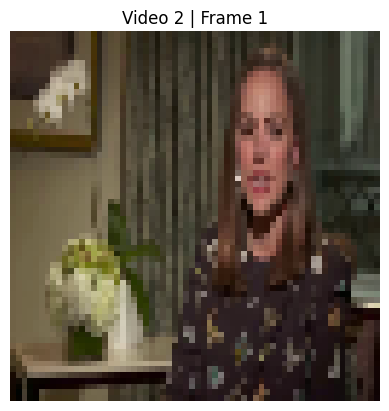

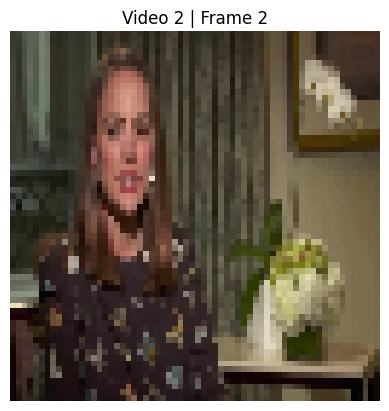

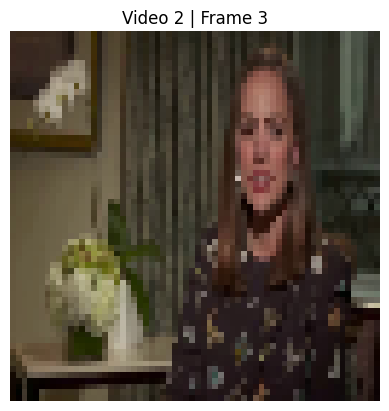

Video 3/6529 | Label: Fake | Total Frames: 10


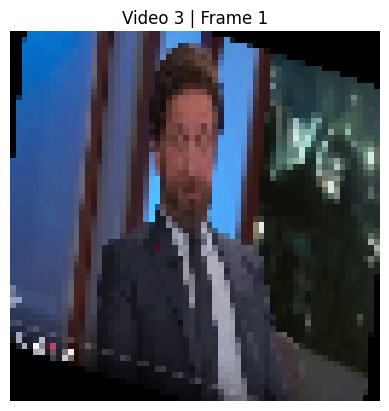

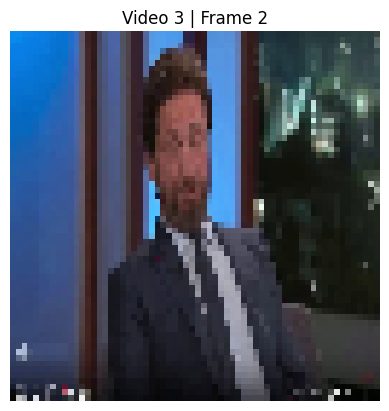

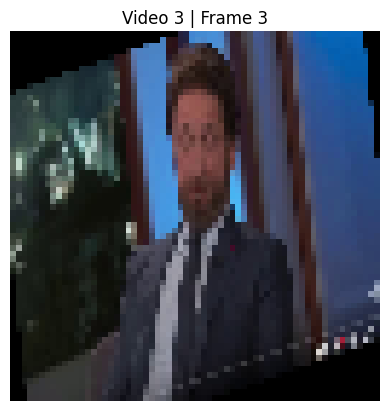

Video 4/6529 | Label: Fake | Total Frames: 10


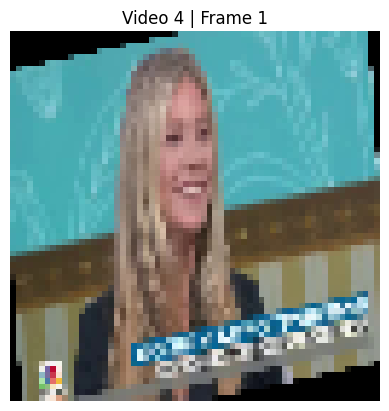

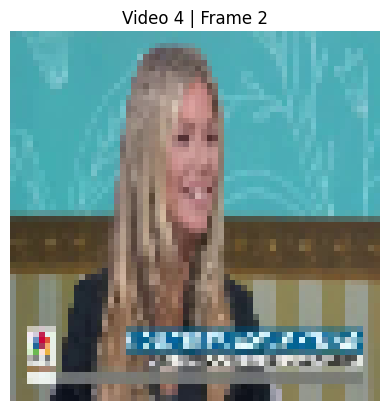

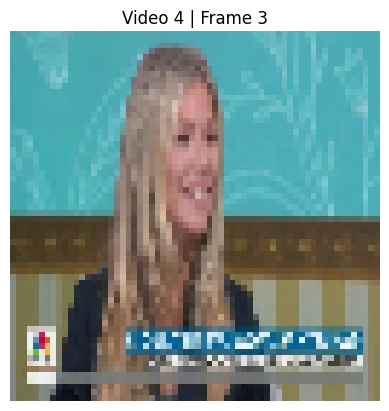

Video 5/6529 | Label: Fake | Total Frames: 10


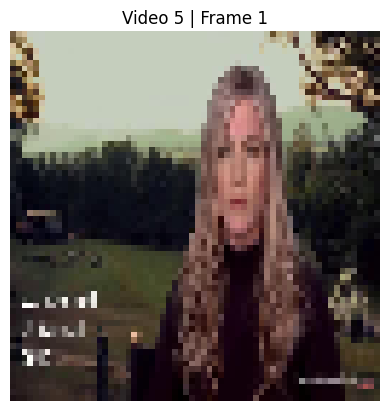

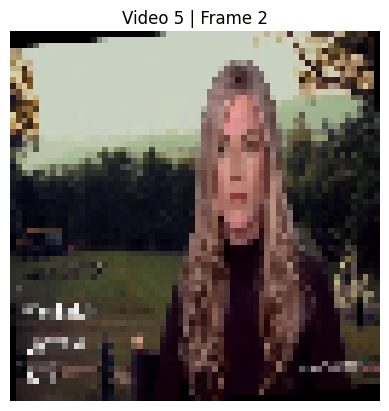

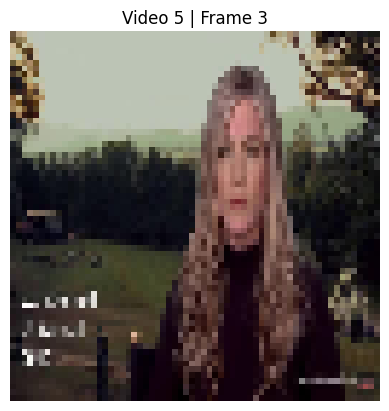

In [20]:
print_preprocessed_frames(
    h5_file_path=h5_file_path,
    num_videos_to_print=5,
    num_frames_to_print=3
)


In [21]:
# Count the number of samples for each class
real_samples = np.sum(y == 0)
fake_samples = np.sum(y == 1)

# Print the class distribution
print(f"Class distribution:")
print(f"Real samples (0): {real_samples}")
print(f"Fake samples (1): {fake_samples}")

# Optionally, print the total number of samples
print(f"Total samples: {len(y)}")


Class distribution:
Real samples (0): 890
Fake samples (1): 5639
Total samples: 6529


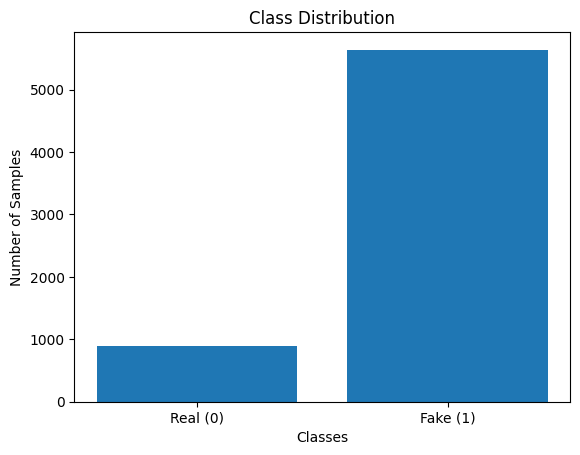

In [22]:
# Count the number of samples for each class
real_samples = np.sum(y == 0)
fake_samples = np.sum(y == 1)

# Create a bar chart
classes = ['Real (0)', 'Fake (1)']
counts = [real_samples, fake_samples]

plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()



Data looks imbalanced

In [23]:
# Ensure X and y are numpy arrays
X = np.array(X)
y = np.array(y)

# Print original dataset distribution
print("Original dataset distribution:")
print("Real samples:", np.sum(y == 0))
print("Fake samples:", np.sum(y == 1))

# Reshape X to 2D for oversampling
X_reshaped = X.reshape((X.shape[0], -1))  # Flatten the data for RandomOverSampler

# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_reshaped, y)

# Reshape X back to its original shape
X_balanced = X_balanced.reshape((-1,) + X.shape[1:])

# Print balanced dataset distribution
print("\nBalanced dataset distribution:")
print("Real samples:", np.sum(y_balanced == 0))
print("Fake samples:", np.sum(y_balanced == 1))


Original dataset distribution:
Real samples: 890
Fake samples: 5639

Balanced dataset distribution:
Real samples: 5639
Fake samples: 5639


In [24]:
# Shuffle the balanced dataset
indices = np.arange(len(X_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]


# Split the balanced dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Print dataset shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")


Training set: (6766, 10, 64, 64, 4), Labels: (6766,)
Validation set: (2256, 10, 64, 64, 4), Labels: (2256,)
Test set: (2256, 10, 64, 64, 4), Labels: (2256,)


In [25]:
# Calculate percentages for training set
real_train_pct = (np.sum(y_train == 0) / len(y_train)) * 100
fake_train_pct = (np.sum(y_train == 1) / len(y_train)) * 100

# Print percentages for training set
print("Training set distribution (percentages):")
print(f"Real samples: {real_train_pct:.2f}%")
print(f"Fake samples: {fake_train_pct:.2f}%")

# Calculate percentages for validation set
real_val_pct = (np.sum(y_val == 0) / len(y_val)) * 100
fake_val_pct = (np.sum(y_val == 1) / len(y_val)) * 100

# Print percentages for validation set
print("Validation set distribution (percentages):")
print(f"Real samples: {real_val_pct:.2f}%")
print(f"Fake samples: {fake_val_pct:.2f}%")

Training set distribution (percentages):
Real samples: 50.00%
Fake samples: 50.00%
Validation set distribution (percentages):
Real samples: 50.00%
Fake samples: 50.00%


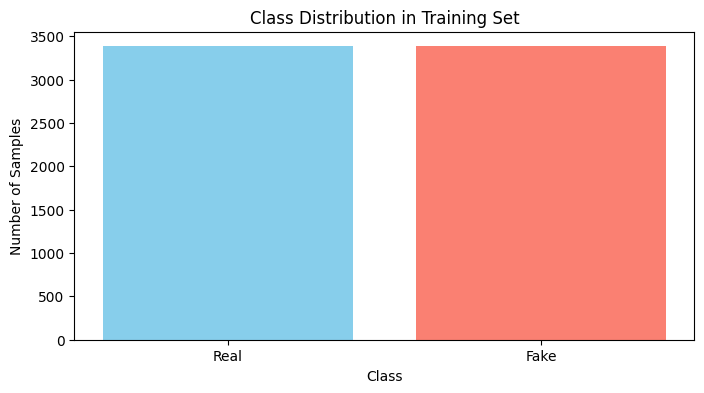

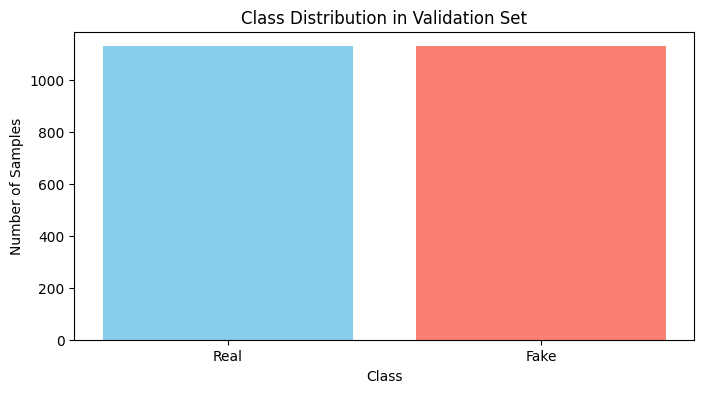

In [26]:
# Visualize class distribution in training set
labels = ['Real', 'Fake']
train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]

plt.figure(figsize=(8, 4))
plt.bar(labels, train_counts, color=['skyblue', 'salmon'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Visualize class distribution in validation set
val_counts = [np.sum(y_val == 0), np.sum(y_val == 1)]

plt.figure(figsize=(8, 4))
plt.bar(labels, val_counts, color=['skyblue', 'salmon'])
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


In [27]:
print("Y_train shape:", y_train.shape)
print("Y_train unique values:", np.unique(y_train))


Y_train shape: (6766,)
Y_train unique values: [0 1]


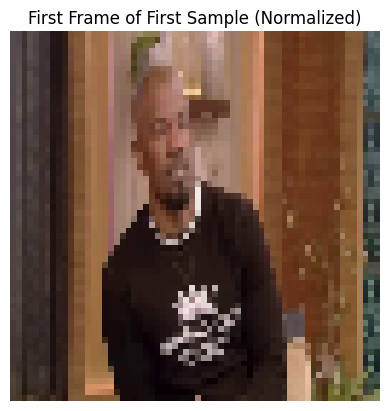

In [28]:
# Use only the first three channels (RGB)
rgb_image = X_train[0][0][..., :3]
  # Take only RGB channels
plt.imshow(rgb_image)
plt.title("First Frame of First Sample (Normalized)")
plt.axis('off')
plt.show()


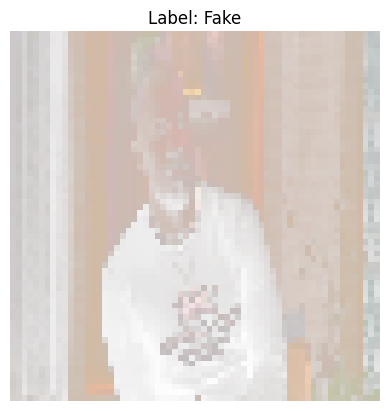

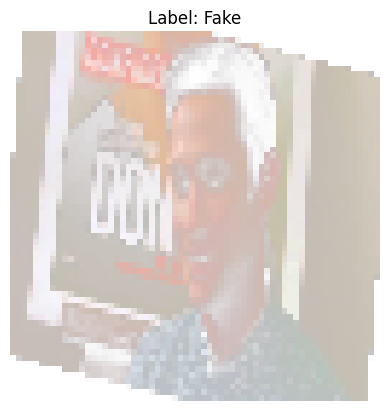

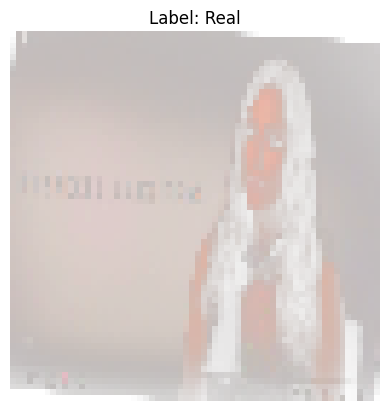

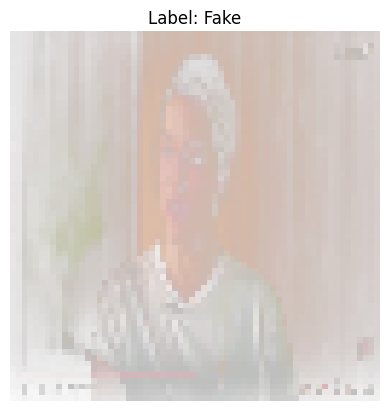

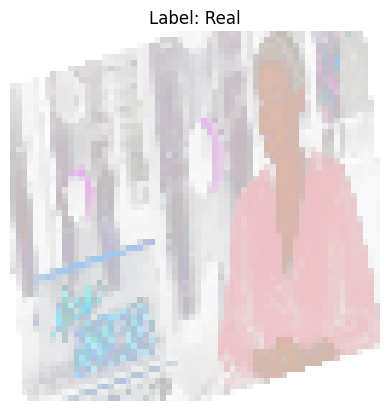

In [29]:
for i in range(5):
    plt.imshow(X_train[i][0])
    plt.title(f"Label: {'Real' if y_train[i] == 0 else 'Fake'}")
    plt.axis('off')
    plt.show()


In [30]:
print("Pixel value range for first sample:", X_train[0].min(), "-", X_train[0].max())

Pixel value range for first sample: 0.0 - 1.0


In [31]:
# Set the number of videos to use for training
num_train_videos = 2000

# Randomly sample indices from the training set
train_indices = np.random.choice(len(X_train), num_train_videos, replace=False)

# Subset the training data
X_train_subset = X_train[train_indices]
y_train_subset = y_train[train_indices]

# Print the new training set distribution
real_samples = np.sum(y_train_subset == 0)
fake_samples = np.sum(y_train_subset == 1)
print(f"Subset training set distribution:")
print(f"Real samples: {real_samples}")
print(f"Fake samples: {fake_samples}")
print(f"Subset X_train shape: {X_train_subset.shape}")
print(f"Subset y_train shape: {y_train_subset.shape}")


Subset training set distribution:
Real samples: 982
Fake samples: 1018
Subset X_train shape: (2000, 10, 64, 64, 4)
Subset y_train shape: (2000,)


In [32]:
# Validation set distribution
real_val = np.sum(y_val == 0)
fake_val = np.sum(y_val == 1)
print(f"Validation set distribution: Real samples: {real_val}, Fake samples: {fake_val}")

# Test set distribution (if available)
real_test = np.sum(y_test == 0)
fake_test = np.sum(y_test == 1)
print(f"Test set distribution: Real samples: {real_test}, Fake samples: {fake_test}")


Validation set distribution: Real samples: 1128, Fake samples: 1128
Test set distribution: Real samples: 1128, Fake samples: 1128


# Data is Process and looks good for training

# NAS with Autokeras

In [33]:
# Parameters
num_frames_per_sequence = 10
subset_size = 5000

# Get the shape of the balanced dataset
num_samples, num_frames, height, width, channels = X_balanced.shape

# Reshape the data to treat each frame as a separate sample
X_balanced_reshape = X_balanced.reshape((-1, height, width, channels))
y_balanced_reshape = np.repeat(y_balanced, num_frames, axis=0)

# Subset the reshaped data
X_subset, _, y_subset, _ = train_test_split(
    X_balanced_reshape, y_balanced_reshape, train_size=subset_size, random_state=42, stratify=y_balanced_reshape
)

# Split the subset data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=42, stratify=y_subset
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print the shapes of the final splits
print("Final Split Shapes:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Final Split Shapes:
X_train shape: (3500, 64, 64, 4), y_train shape: (3500,)
X_val shape: (750, 64, 64, 4), y_val shape: (750,)
X_test shape: (750, 64, 64, 4), y_test shape: (750,)


In [34]:
from re import search
# Create the image-based AutoKeras model
search = ak.ImageClassifier(max_trials=5, overwrite=True)

# Train the NAS model
history = search.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))
print(history.history.keys())

# Export the best model architecture
best_model = search.export_model()

# Print the model summary
best_model.summary()

Trial 5 Complete [00h 00m 27s]
val_loss: 0.6693521738052368

Best val_loss So Far: 0.6667730212211609
Total elapsed time: 01h 24m 39s
Epoch 1/4
110/110 [==============================] - 6s 47ms/step - loss: 0.7048 - accuracy: 0.5483 - val_loss: 0.6688 - val_accuracy: 0.5440
Epoch 2/4
110/110 [==============================] - 5s 46ms/step - loss: 0.6526 - accuracy: 0.6229 - val_loss: 0.6797 - val_accuracy: 0.5520
Epoch 3/4
110/110 [==============================] - 5s 47ms/step - loss: 0.6072 - accuracy: 0.6720 - val_loss: 0.6943 - val_accuracy: 0.5933
Epoch 4/4
110/110 [==============================] - 5s 46ms/step - loss: 0.5472 - accuracy: 0.7200 - val_loss: 0.6983 - val_accuracy: 0.5960


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 4)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 4)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 4)        9         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        1184      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 

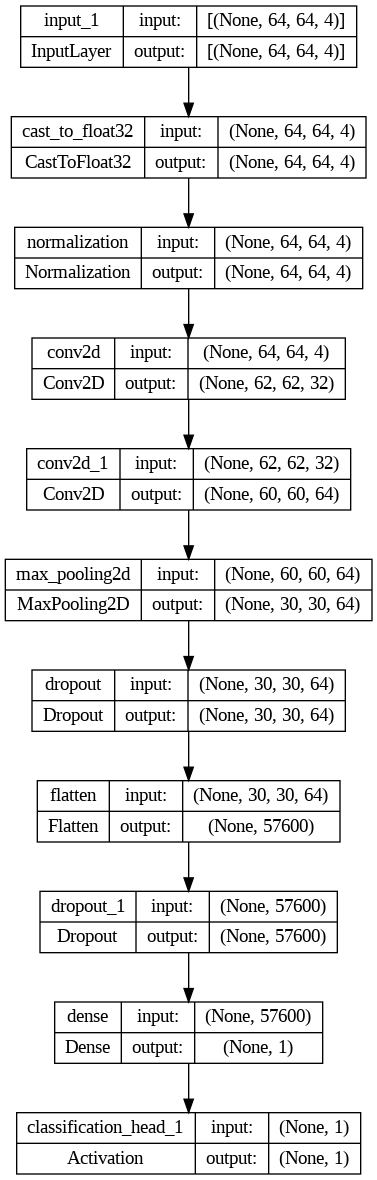

In [35]:
# Plot the model architecture
plot_model(best_model, show_shapes=True, to_file="best_model.png")

In [36]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history=best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the val data
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/20
110/110 [==============================] - 6s 47ms/step - loss: 0.5102 - accuracy: 0.7431 - val_loss: 0.6562 - val_accuracy: 0.6507
Epoch 2/20
110/110 [==============================] - 5s 46ms/step - loss: 0.4592 - accuracy: 0.7891 - val_loss: 0.6822 - val_accuracy: 0.6427
Epoch 3/20
110/110 [==============================] - 5s 45ms/step - loss: 0.4299 - accuracy: 0.7991 - val_loss: 0.6752 - val_accuracy: 0.6587
Epoch 4/20
110/110 [==============================] - 5s 46ms/step - loss: 0.4153 - accuracy: 0.8129 - val_loss: 0.6943 - val_accuracy: 0.6387
Epoch 5/20
110/110 [==============================] - 5s 45ms/step - loss: 0.3846 - accuracy: 0.8237 - val_loss: 0.6997 - val_accuracy: 0.6387
Epoch 6/20
110/110 [==============================] - 5s 47ms/step - loss: 0.3529 - accuracy: 0.8480 - val_loss: 0.7046 - val_accuracy: 0.6467
Epoch 7/20
110/110 [==============================] - 5s 46ms/step - loss: 0.3437 - accuracy: 0.8480 - val_loss: 0.7297 - val_accuracy: 0.6400

24/24 [==============================] - 0s 8ms/step
Precision: 0.6348
Recall: 0.6720
F1 Score: 0.6528
ROC AUC Score: 0.6748

Classification Report:
              precision    recall  f1-score   support

        Real       0.65      0.61      0.63       375
        Fake       0.63      0.67      0.65       375

    accuracy                           0.64       750
   macro avg       0.64      0.64      0.64       750
weighted avg       0.64      0.64      0.64       750


Confusion Matrix:
[[230 145]
 [123 252]]


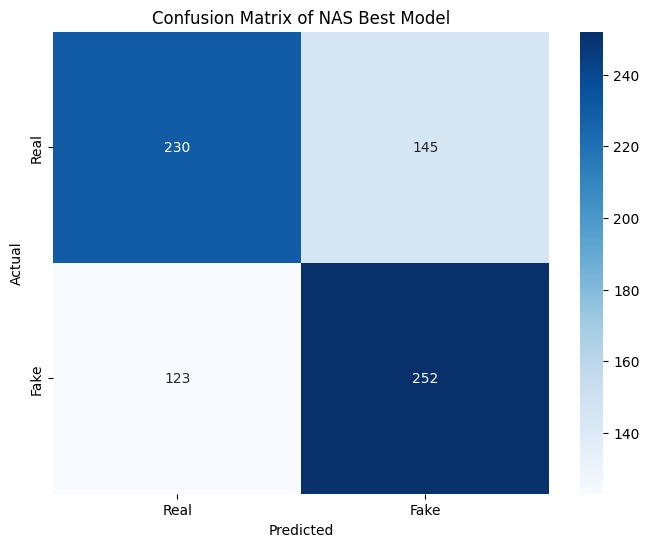

In [37]:
predictions = best_model.predict(X_test)

# Convert predictions to labels (0 = Real, 1 = Fake)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate classification metrics
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)

# Print the precision, recall, F1 score, and ROC-AUC
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

#  Print the Detailed Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=['Real', 'Fake']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))


# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of NAS Best Model')
plt.show()

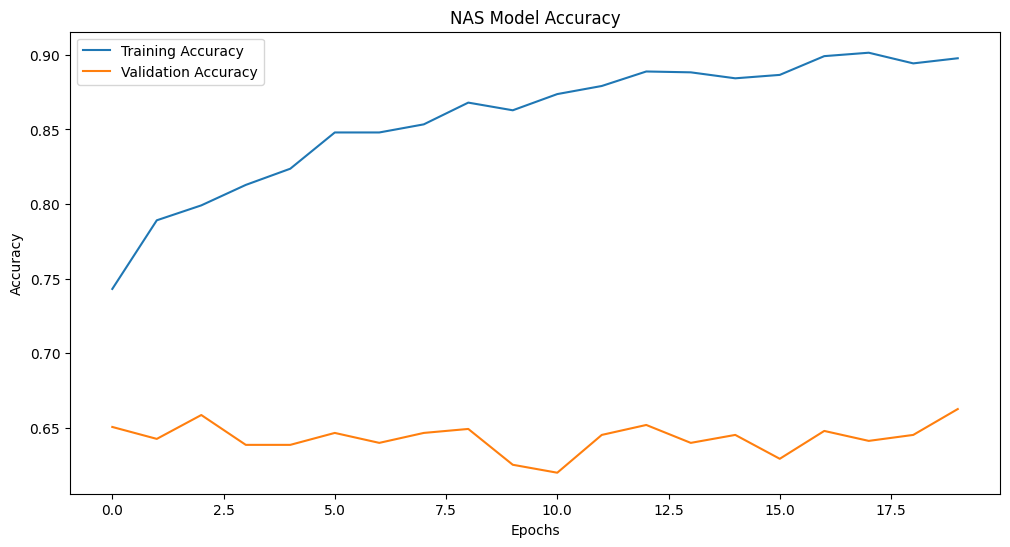

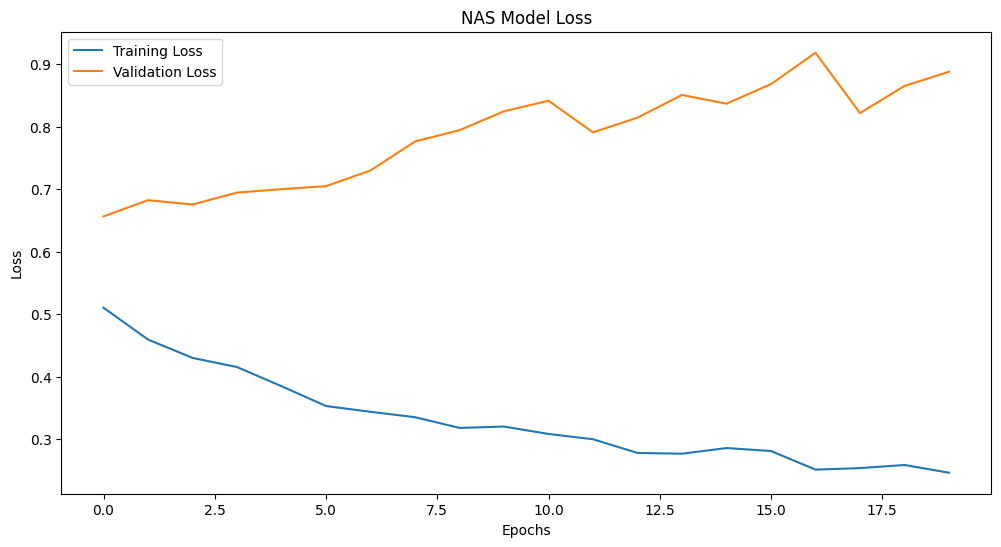

In [47]:
# Plot training history for CNN-LSTM
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('NAS Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NAS Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()